--- Loading Dataset ---
Dataset loaded successfully!
Available columns: ['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw', 'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3', 'commissioning_year', 'owner', 'source', 'url', 'geolocation_source', 'wepp_id', 'year_of_capacity_data', 'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018', 'generation_gwh_2019', 'generation_data_source', 'estimated_generation_gwh']
Using 'primary_fuel' as the primary fuel column.

--- Data Exploration ---

.info() - DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11879 entries, 0 to 11878
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   11879 non-null  object 
 1   country_long              11879 non-null  object 
 2   name          

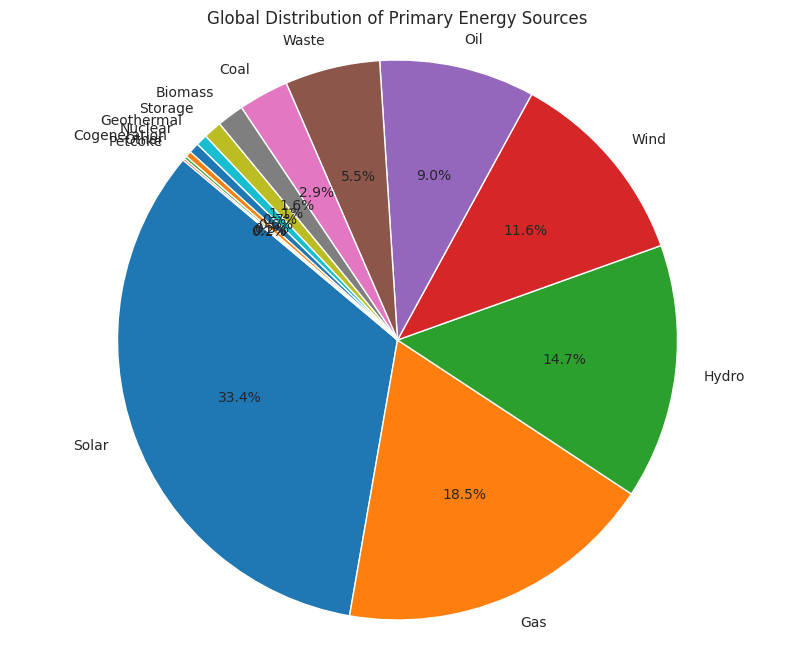

Dataset contains only United States data. Showing fuel type distribution for the USA.


/tmp/ipython-input-2362110555.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fuel_type_capacity_usa.index, y=fuel_type_capacity_usa.values, palette="viridis")


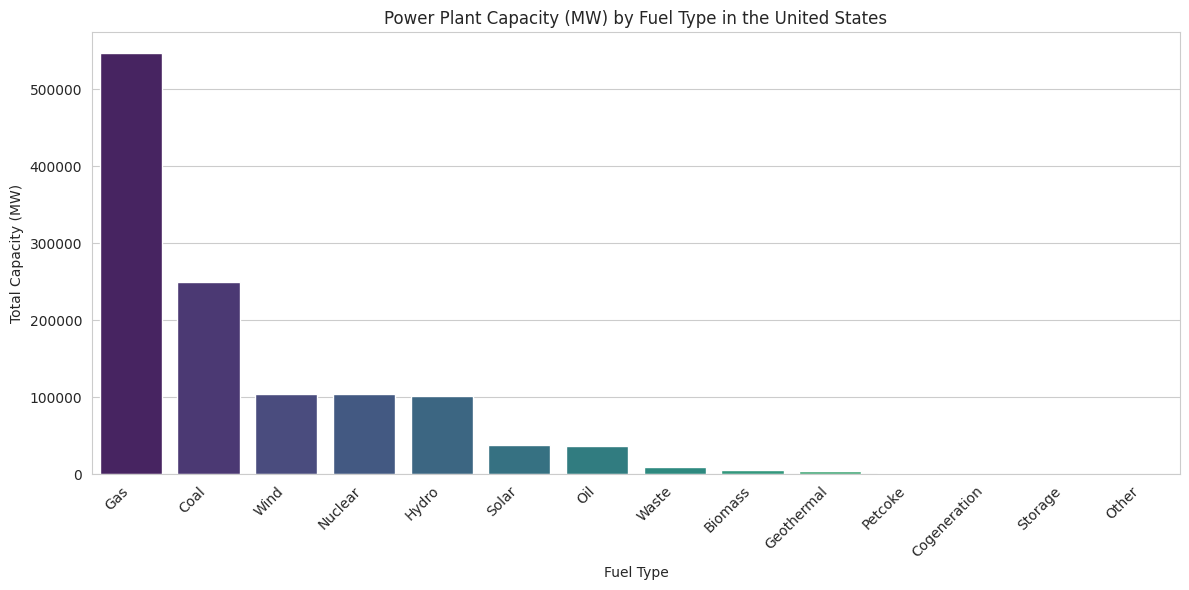

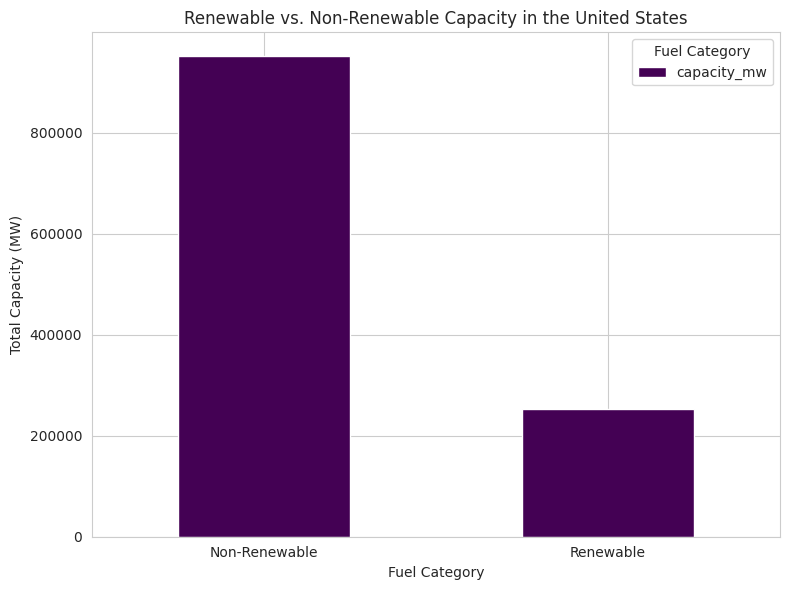


--- Data Splitting ---
Training set shape: (7880, 24335)
Testing set shape: (1970, 24335)

Data splitting is complete. This prepares the data for model training in future weeks.
--- End of Week 1 & A Head Start! ---


In [21]:
# ⚡️ The Sustainable Energy & Efficiency Project ⚡️

# 1. Import necessary libraries
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys

# --- WEEK 1 REQUIREMENTS ---
# 2. Load the dataset
print("--- Loading Dataset ---")
try:
    df = pd.read_csv('global_power_plant_database.csv')
    print("Dataset loaded successfully!")
    # Strip whitespace from column names to prevent KeyErrors
    df.columns = df.columns.str.strip()
except FileNotFoundError:
    print("Error: 'global_power_plant_database.csv' not found. Please download the dataset and place it in the same directory.")
    # Removed sys.exit() to prevent premature termination
    pass

# Detect which column contains the fuel type
print("Available columns:", df.columns.tolist())
possible_names = ['primary_fuel', 'fuel1', 'fuel_type', 'plant_primary_fuel']
fuel_col = None
for name in possible_names:
    if name in df.columns:
        fuel_col = name
        break

if fuel_col is None:
    raise KeyError("No column for primary fuel found in dataset. Please check dataset columns.")

print(f"Using '{fuel_col}' as the primary fuel column.")

# 3. Explore the dataset
print("\n--- Data Exploration ---")
print("\n.info() - DataFrame Information:")
df.info()

print("\n.describe() - Statistical Summary:")
print(df.describe())

print("\n.isnull().sum() - Missing Values:")
print(df.isnull().sum())

# --- Data Preprocessing ---
print("\n--- Data Preprocessing ---")

print(f"Original shape: {df.shape}")
df_cleaned = df.dropna(subset=[fuel_col]).copy()
print(f"Shape after dropping rows with missing '{fuel_col}': {df_cleaned.shape}")

# Drop columns with >50% missing values
threshold = len(df_cleaned) * 0.5
df_cleaned = df_cleaned.dropna(axis=1, thresh=threshold)
print(f"Shape after dropping columns with >50% missing values: {df_cleaned.shape}")

# Fill missing numeric values with mean
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
for col in numerical_cols:
    mean_value = df_cleaned[col].mean()
    df_cleaned[col] = df_cleaned[col].fillna(mean_value)

print("\nMissing values after cleaning:")
print(df_cleaned.isnull().sum())

# Create fuel_category column before visualizations and splitting data
renewable_fuels = ['Hydro', 'Solar', 'Wind', 'Biomass', 'Geothermal', 'Wave and Tidal']
df_cleaned['fuel_category'] = df_cleaned[fuel_col].apply(
    lambda x: 'Renewable' if x in renewable_fuels else 'Non-Renewable'
)

# --- EDA & Visualizations ---
print("\n--- Generating Visualizations ---")
sns.set_style("whitegrid")

# Visualization 1: Pie chart of global energy source distribution
primary_fuel_counts = df_cleaned[fuel_col].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(primary_fuel_counts, labels=primary_fuel_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Global Distribution of Primary Energy Sources')
plt.axis('equal')
plt.show()

# Visualization 2: Bar chart of installed capacity by country or fuel type (depending on dataset)
if 'country_long' not in df_cleaned.columns:
    raise KeyError("The dataset does not contain 'country_long' column required for country-level analysis.")

# Filter for United States data if only USA data is present
if df_cleaned['country_long'].nunique() == 1 and df_cleaned['country_long'].iloc[0] == 'United States of America':
    print("Dataset contains only United States data. Showing fuel type distribution for the USA.")
    fuel_type_capacity_usa = df_cleaned.groupby(fuel_col)['capacity_mw'].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=fuel_type_capacity_usa.index, y=fuel_type_capacity_usa.values, palette="viridis")
    plt.title('Power Plant Capacity (MW) by Fuel Type in the United States')
    plt.xlabel('Fuel Type')
    plt.ylabel('Total Capacity (MW)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualization 3: Stacked bar chart for renewable vs. non-renewable for the United States
    renewable_non_renewable_capacity_usa = df_cleaned.groupby('fuel_category')['capacity_mw'].sum()

    fig, ax = plt.subplots(figsize=(8, 6))
    # Plotting directly from the Series
    renewable_non_renewable_capacity_usa.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title('Renewable vs. Non-Renewable Capacity in the United States')
    ax.set_xlabel('Fuel Category')
    ax.set_ylabel('Total Capacity (MW)')
    ax.legend(title='Fuel Category')
    plt.xticks(rotation=0, ha='center') # No rotation needed for two categories
    plt.tight_layout()
    plt.show()

else:
    # Original code for global data visualization (if a global dataset is used)
    country_capacity = df_cleaned.groupby('country_long')['capacity_mw'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=country_capacity.index, y=country_capacity.values, palette="viridis")
    plt.title('Top 10 Countries by Total Power Plant Capacity (MW)')
    plt.xlabel('Country')
    plt.ylabel('Total Capacity (MW)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualization 3: Stacked bar chart for renewable vs. non-renewable for Top 10 Countries
    top_10_countries = country_capacity.index
    df_top10 = df_cleaned[df_cleaned['country_long'].isin(top_10_countries)]

    renewable_non_renewable_capacity = df_top10.groupby(['country_long', 'fuel_category'])['capacity_mw'].sum().unstack(fill_value=0)
    renewable_non_renewable_capacity = renewable_non_renewable_capacity.reindex(top_10_countries)

    fig, ax = plt.subplots(figsize=(14, 8))
    renewable_non_renewable_capacity.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title('Renewable vs. Non-Renewable Capacity for Top 10 Countries')
    ax.set_xlabel('Country')
    ax.set_ylabel('Total Capacity (MW)')
    ax.legend(title='Fuel Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# --- Data Splitting ---
print("\n--- Data Splitting ---")

features = df_cleaned.drop([fuel_col, 'fuel_category'], axis=1, errors='ignore') # Drop fuel_category as well
target = df_cleaned[fuel_col]

# Only encode categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=categorical_cols)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("\nData splitting is complete. This prepares the data for model training in future weeks.")
print("--- End of Week 1 & A Head Start! ---")